# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.segmentation import slic
from skimage.color import label2rgb
from sklearn.preprocessing import StandardScaler
from skimage.color import rgba2rgb

## Generating the data

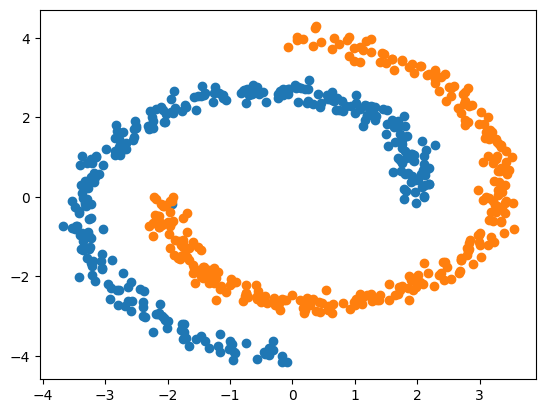

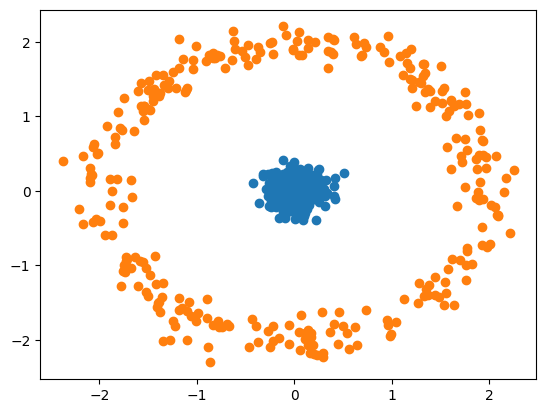

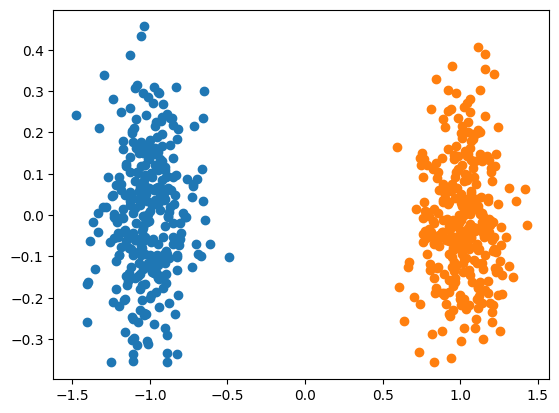

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      c:\users\soelm\documents\04_code\mva\graphs_for_ml\spectral_clustering\spectral_clustering\generate_data.py
Type:      function

In [2]:
# Example

for fn in [two_moons, point_and_circle, blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [3]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
    similarities = np.zeros((n,n))

    for i in range(n):
        for j in range(i+1, n):
            sim =  np.exp(-(np.linalg.norm(X[i, :] - X[j, :])**2)/(2*var))
            similarities[i, j] = sim
            similarities[j, i] = sim

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        for i in range(n):
            for j in range(i+1, n):
                if similarities[i,j] >= eps:
                    W[j,i]=similarities[i,j]
                    W[i,j]=similarities[i,j]

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for i in range(n):
            k_n = np.argsort(similarities[i,:])[-(k+1):]
            for j in range(n):
                if i!=j and j in k_n:
                    W[i,j]=similarities[i,j]
        W = (W +W.T)/2
                            
    return W


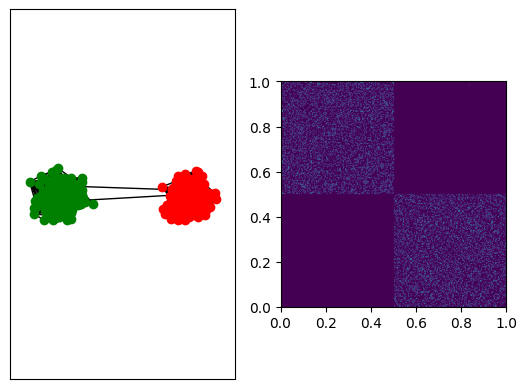

In [ ]:
# Example

W = build_similarity_graph(X, k=20)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  

## Computing the Laplacian

In [5]:
import numpy as np

def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    # Degree matrix
    D = np.diag(np.sum(W, axis=1))

    if laplacian_normalization == 'unn':
        # Unnormalized Laplacian
        L = D - W

    elif laplacian_normalization == 'sym':
        # Symmetric normalized Laplacian
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
        L = np.eye(W.shape[0]) - D_inv_sqrt @ W @ D_inv_sqrt

    elif laplacian_normalization == 'rw':
        # Random-walk normalized Laplacian
        D_inv = np.diag(1.0 / np.diag(D))
        L = np.eye(W.shape[0]) - D_inv @ W

    return L

## Clustering

In [14]:
import scipy
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E, U = scipy.linalg.eigh(L)

    idx = np.argsort(E)
    E = E[idx]
    U = U[:, idx]

    if chosen_eig_indices is None:
        chosen_eig_indices = range(1, num_classes+1)
    selected_U = U[:, chosen_eig_indices]

    row_norms = np.linalg.norm(selected_U, axis=1, keepdims=True)
    eps = 1e-15
    normalized_U = selected_U / (row_norms + eps)

    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    Y = kmeans.fit_predict(normalized_U)

    return Y

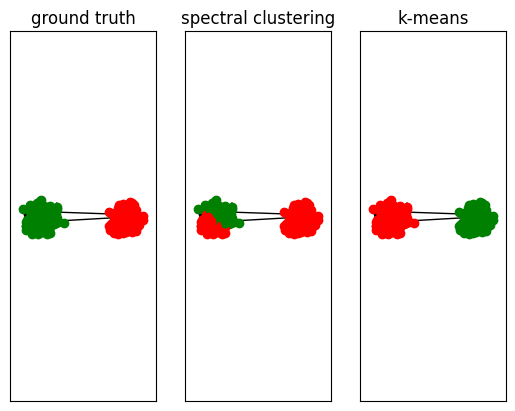

In [15]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [194]:
def parameter_sensitivity(parameter_type = 'eps', parameter_candidate = [1, 2]):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """

    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [18]:
def image_segmentation(input_img='four_elements.bmp', var=1.0, k=20, num_classes=5, chosen_eig_indices=None, laplacian_normalization = 'unn'):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """


    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

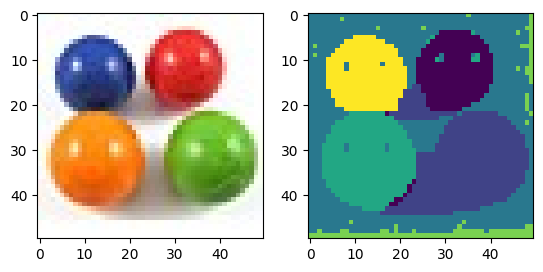

In [27]:
image_segmentation(var=1.0, k=20, num_classes=6, chosen_eig_indices=None, laplacian_normalization = 'sym') #sym rw unn

# Questions

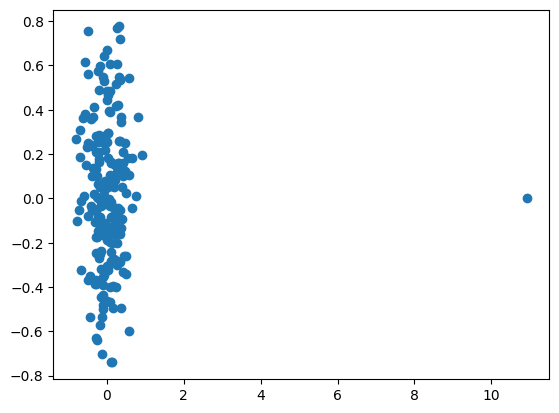

In [68]:
# Example

X, Y = worst_case_blob(num_samples=200, delta=10)
plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:


### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

According to the docstring, worst_case_blob() generates:
- a gaussian blob (mean=0, std=1) with 'num_samples'-1 points
- another blob consisting of only one point at distance 'delta' from the first one

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

In [92]:
num_samples = 200
X, Y = worst_case_blob(num_samples=num_samples, delta=2)
W = build_similarity_graph(X, eps=0.05)

span_tree = min_span_tree(W)
if np.sum(span_tree)==num_samples-1:
    print("Graph connected")
else:
    print("Graph not connected")

Graph connected


When delta increases, it is very hard to keep the graph connected and eps needs to be smaller to catch the outlier. This approach is not the best because it can be hard to choose a good eps to ensure the full connectivity of the data while keeping its original structure.


### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

It is important to build a connected graph for spectral clustering otherwise there will be a cluster for each non connected component assocciated to the 0 eigenvalue.
k-NN is more robust as it will ensure connexions even for outliers and full connectivity can be achieved with small k. On the other hand, eps-graph can be usefull for well structured data when an optimal eps can easily be identified.  Otherwise, it is difficult to ensure full connectivity while keeping the original structure of the data.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

Graph connected


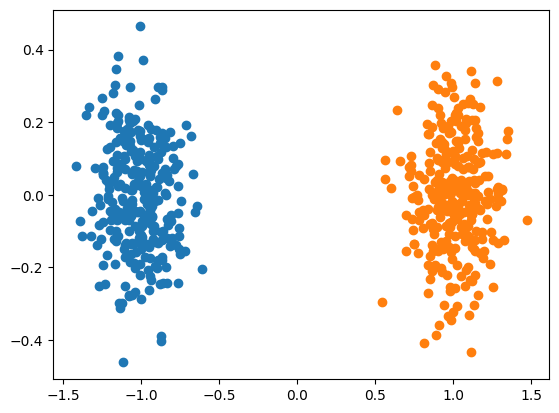

In [132]:
num_samples = 600
X, Y = blobs(num_samples=num_samples)
#plot_clusters(X, Y)

W = build_similarity_graph(X, eps=0.5)

span_tree = min_span_tree(W)
if np.sum(span_tree)==num_samples-1:
    print("Graph connected")
else:
    print("Graph not connected")


# Clustering using spectral_clustering

L = build_laplacian(W, laplacian_normalization='unn')

Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=2)

plot_clusters(X, Y_rec)

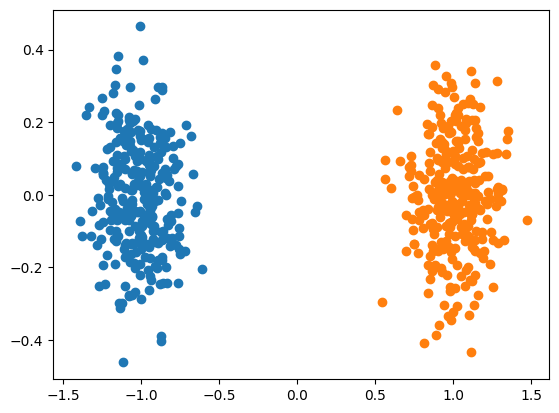

In [133]:
# Clustering using built-in K-means
kmeans = KMeans(n_clusters=2, random_state=42)
Y_kmeans = kmeans.fit_predict(X)

plot_clusters(X, Y_kmeans)

I chose [1] for the eigenvectors because is is associated to the smallest nonzero eigenvalue of the Laplacian as the first eigenvector associated with 0 corresponds to a constant function and does not bring additional information.

Both spectral clustering and the built-in k-means reach the same results on this example, this can be explained by the easy setup with two distinct blobs suiting well to k-means with k=2. Inter-blob distance is bigger than maximum distance within a blob.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

Graph not connected


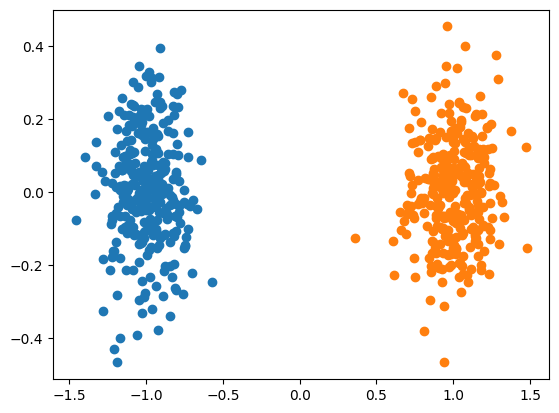

In [140]:
num_samples = 600
X, Y = blobs(num_samples=num_samples)
#plot_clusters(X, Y)

W = build_similarity_graph(X, eps=0.7)

span_tree = min_span_tree(W)
if np.sum(span_tree)==num_samples-1:
    print("Graph connected")
else:
    print("Graph not connected")


# Clustering using spectral_clustering

L = build_laplacian(W, laplacian_normalization='unn')

Y_rec = spectral_clustering(L, chosen_eig_indices=[0], num_classes=2)

plot_clusters(X, Y_rec)

This time, I only used the first eigenvector [0] as the graph is not connected so the first eigenvector indicates the first non connected components which is the first cluster. I could also have chosen the second one as it indicates the 2nd cluster as well.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

In [146]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.linalg import eigh

def spectral_clustering(L, chosen_eig_indices=None, num_classes=None):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    chosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int or None 
        Number of clusters to compute. If None, determined automatically.

    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """
    E, U = eigh(L)

    idx = np.argsort(E)
    E = E[idx]
    U = U[:, idx]

    if chosen_eig_indices is None:
        if num_classes is None:
            gaps = np.diff(E)  # Differences between consecutive eigenvalues
            num_classes = np.argmax(gaps) + 1

        chosen_eig_indices = range(1, num_classes + 1)  # We don't use the first vector


    selected_U = U[:, chosen_eig_indices]

    row_norms = np.linalg.norm(selected_U, axis=1, keepdims=True)
    eps = 1e-15
    normalized_U = selected_U / (row_norms + eps)

    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    Y = kmeans.fit_predict(normalized_U)

    return Y


Graph connected


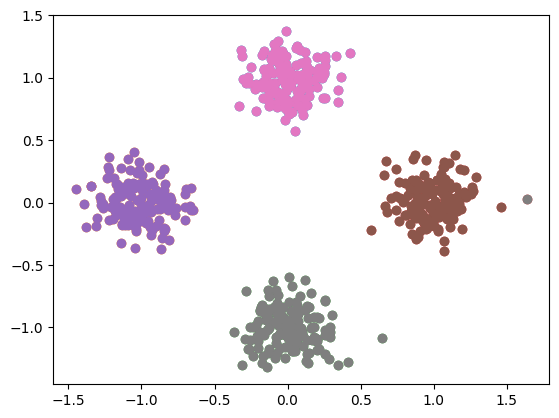

In [151]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=05)
plot_clusters(X, Y)

W = build_similarity_graph(X, eps=0.5)
L = build_laplacian(W, laplacian_normalization='unn')

span_tree = min_span_tree(W)
if np.sum(span_tree)==num_samples-1:
    print("Graph connected")
else:
    print("Graph not connected")

Y_rec = spectral_clustering(L, chosen_eig_indices=None)

plot_clusters(X, Y_rec)

I implemented the spectral gap strategy which selects the number of eigenvectors by looking at the differences between consecutive and sorted eigenvalues and cuts at the biggest difference.

The idea is that eigenvalues of well-spearated clusters will be close to zero then there is a gap with the following eigenvalues.

When the variance of the blobs increases, the spectral gap decreases because the clusters are less defined as blobs overlaps. The eps-value used to generate the graph is less suited as well.



### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I only used k-means in spectral_clustering(). I think this is the standard way of doing as it can work well in high dimentionnal spaces. 

I believe that it would be difficult to implement a version with thresholding when there are many clusters and it may be less robust to overlapping clusters.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

Graph connected


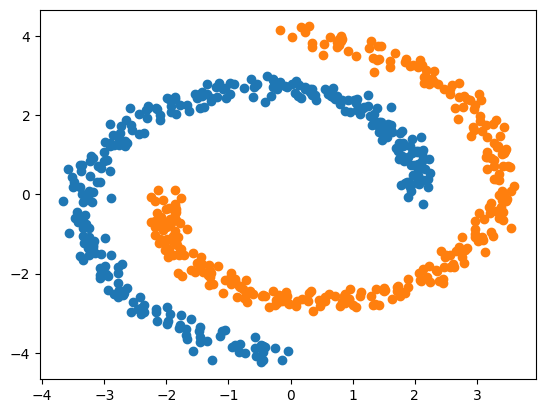

In [169]:
X, Y = two_moons(num_samples=600)
#plot_clusters(X, Y)

W = build_similarity_graph(X, k=10)

span_tree = min_span_tree(W)
if np.sum(span_tree)==num_samples-1:
    print("Graph connected")
else:
    print("Graph not connected")


# Clustering using spectral_clustering

L = build_laplacian(W, laplacian_normalization='unn')

Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=2)

plot_clusters(X, Y_rec)

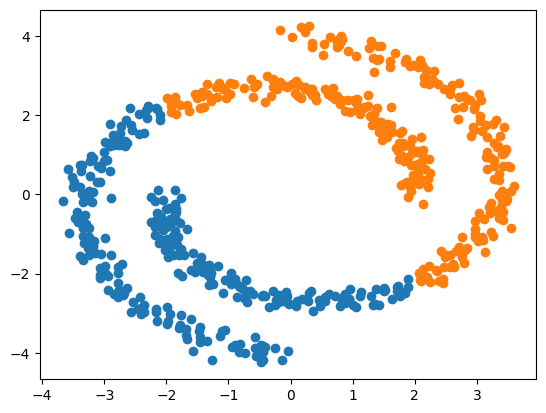

In [170]:
# Clustering using built-in K-means
kmeans = KMeans(n_clusters=2, random_state=42)
Y_kmeans = kmeans.fit_predict(X)

plot_clusters(X, Y_kmeans)

It seems that k-means struggles to separate clusters whereas spectral clustering is doing well. 

This may due to the non convexity of the envelopes of the clusters because k-means relies on Euclidian distance and suggests that clusters are convexs.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

Graph not connected


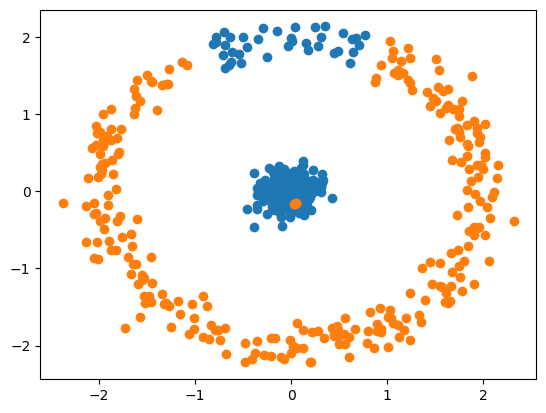

In [190]:

X, Y = point_and_circle(num_samples=600)

W = build_similarity_graph(X, k=2)

span_tree = min_span_tree(W)
if np.sum(span_tree)==num_samples-1:
    print("Graph connected")
else:
    print("Graph not connected")


# Clustering using normal Laplacian

L = build_laplacian(W, laplacian_normalization='unn')

Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1,2], num_classes=2)

plot_clusters(X, Y_rec)

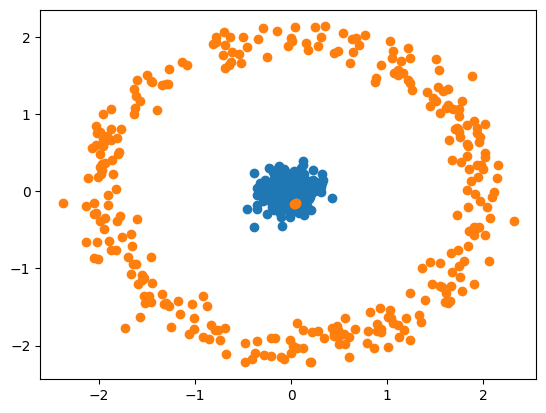

In [192]:
L = build_laplacian(W, laplacian_normalization='rw') #random walk Laplacian

Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1,2], num_classes=2)

plot_clusters(X, Y_rec)

The Random-Walk normalizes the influence of nodes by their degree therefore it should balance the influence of the central dense cluster. 

As you can see, the random-walk Laplacian seems more suited to this problem.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

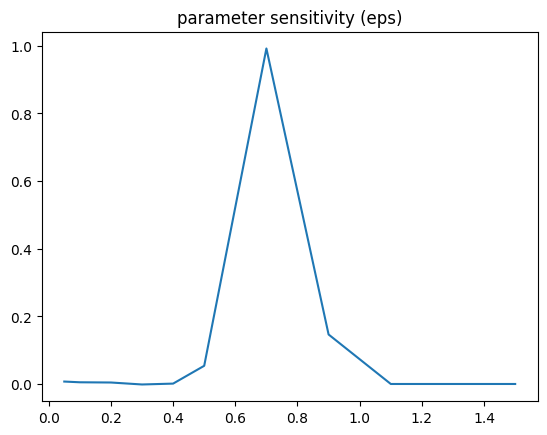

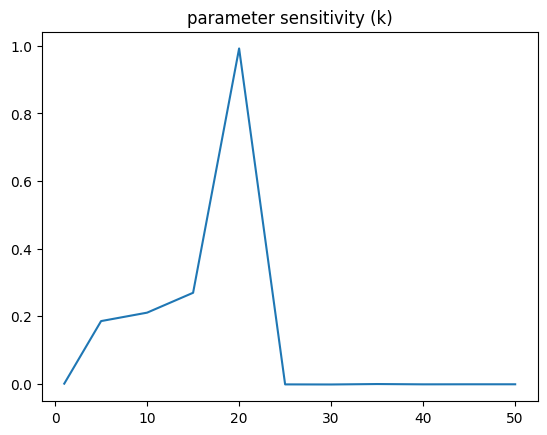

In [197]:
# Sensitivity to epsilon
parameter_type = 'eps'
parameter_candidate = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
parameter_sensitivity(parameter_type, parameter_candidate)

# Sensitivity to k
parameter_type = 'k'
parameter_candidate = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
parameter_sensitivity(parameter_type, parameter_candidate)


We can see that for both k and eps, a too small value leads to bad results as the graph is not "connected enough" to accurately represent data relationships. The same occurs for to big parameters as the graph is 'too connected', which adds noise in the data. 

Therefore, there is an optimal parameter to find, represented by the peak values on the graphs, representing a graph well connected graph.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

First, we could try to vizualize the clustering by plotting some graph like PCA with clusters in different colors, dendrogram etc.

We could also try to have relative comparison between several clustering using metrics such as intra-cluster/inter-cluster variance ratio, silhouette coefficient etc.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

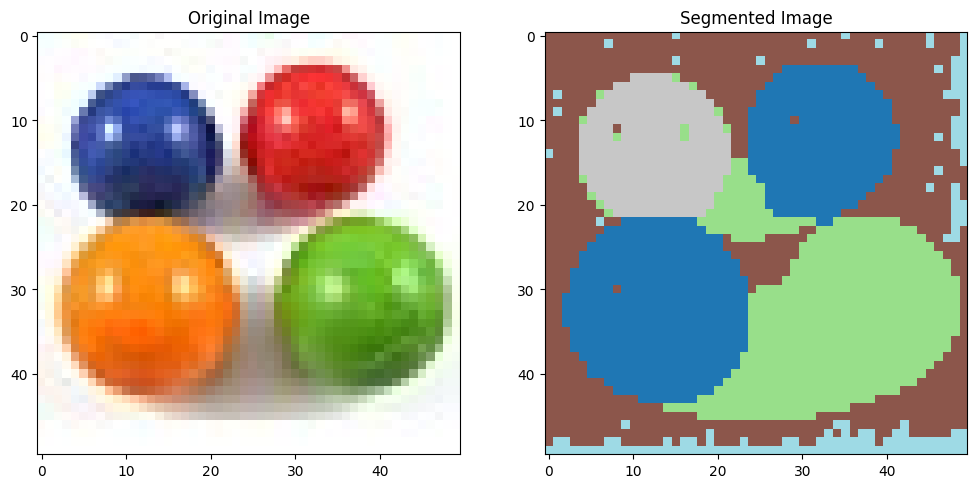

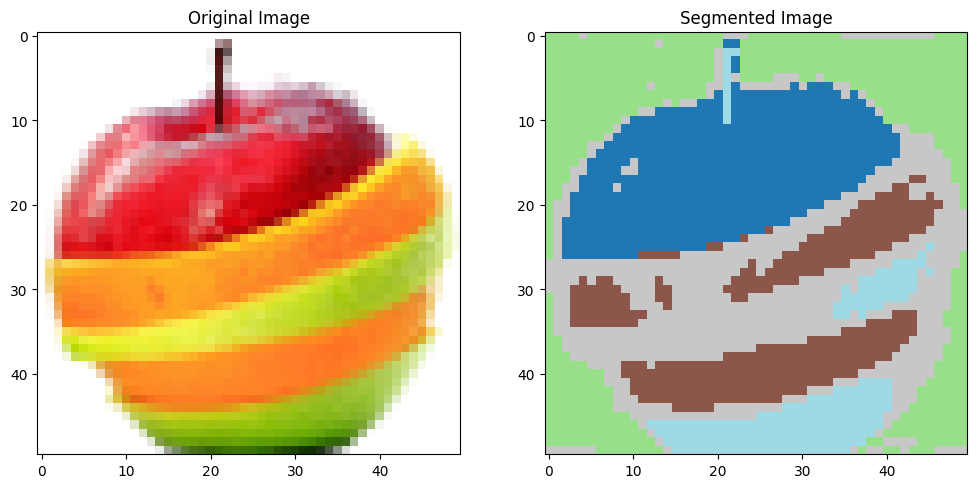

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.preprocessing import StandardScaler

def image_segmentation_(input_img='four_elements.bmp', var=1.0, k=20, num_classes=5, chosen_eig_indices=None, laplacian_normalization='unn'):
    """
    Perform image segmentation using spectral clustering.

    :param input_img: name of the image file in the data folder
    :param var: variance for the Gaussian similarity function
    :param k: number of neighbors for k-NN graph
    :param num_classes: number of segments to divide the image into
    :param chosen_eig_indices: list of eigenvectors to use (None for automatic selection)
    :param laplacian_normalization: type of Laplacian ('unn', 'sym', 'rw')
    """
  
    filename = os.path.join('data', input_img)
    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X)) 

    im_side = X.shape[0]
    Xr = X.reshape(im_side ** 2, 3) 

    # Scale features to have zero mean and unit variance
    scaler = StandardScaler()
    Xr_scaled = scaler.fit_transform(Xr)


    W = build_similarity_graph(Xr_scaled, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)

    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)
    Y_rec = Y_rec.reshape(im_side, im_side)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    plt.title("Segmented Image")
    plt.imshow(Y_rec, cmap='tab20') 

    plt.show()


image_segmentation_(input_img='four_elements.bmp', var=1.0, k=20, num_classes=5, laplacian_normalization='sym')
image_segmentation_(input_img='fruit_salad.bmp', var=1.0, k=15, num_classes=5, laplacian_normalization='rw')


I added a standard scaler to get mean=0 and std=1 for pixel values, the idea was that extrem values should not impact too much the clustering.

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

- An easy method could be to group similar pixel to create "Superpixel".

- We could also try to make graph more spare to limit computation.

- I could also try to developp a Latent Clustering technique. The idea would be to train an encoder-decoder model (like Latent Diffusion Model in image generation) and perform the clustering in the dense latent space which would reduce the dimension of the image. Then the segmentation is upscaled. 

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

Number of initial pixels:  99225
Number of superpixels:  1000


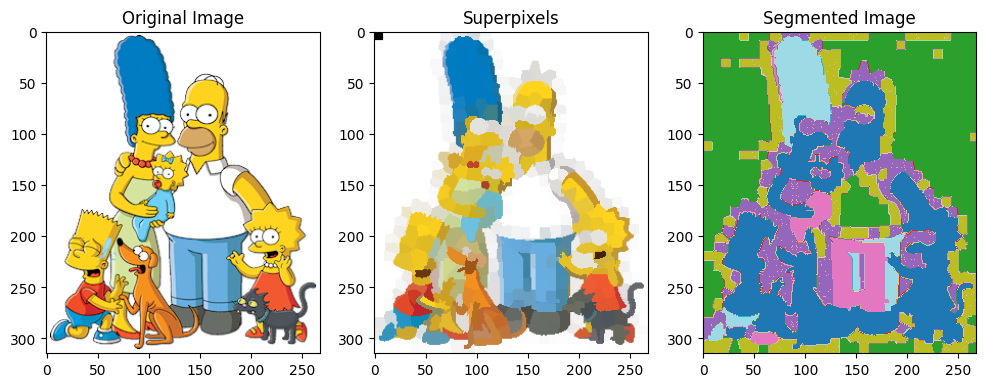

In [215]:

def image_segmentation_superpixels(input_img='big_picture.png', var=1.0, k=20, num_classes=5, 
                                   chosen_eig_indices=None, laplacian_normalization='unn', n_superpixels=500):
    """
    Perform image segmentation using spectral clustering with superpixels.

    :param input_img: name of the image file in the data folder
    :param var: variance for the Gaussian similarity function
    :param k: number of neighbors for k-NN graph
    :param num_classes: number of segments to divide the image into
    :param chosen_eig_indices: list of eigenvectors to use (None for automatic selection)
    :param laplacian_normalization: type of Laplacian ('unn', 'sym', 'rw')
    :param n_superpixels: number of superpixels to generate (reduces computational cost)
    """

 
    filename = os.path.join('data', input_img)
    X = io.imread(filename)

    # Convert RGBA to RGB
    if X.shape[-1] == 4:
        X = rgba2rgb(X)

    X = (X - np.min(X)) / (np.max(X) - np.min(X)) 

    im_side = X.shape[0]
    print('Number of initial pixels: ', im_side**2)
    print('Number of superpixels: ', n_superpixels)

    # Apply SLIC to get superpixels
    superpixels = slic(X, n_segments=n_superpixels, compactness=10, start_label=0)


    n_superpixels = np.max(superpixels) + 1 
    superpixel_features = np.zeros((n_superpixels, 3))  # Store mean RGB values for each superpixel

    for i in range(n_superpixels):
        mask = superpixels == i  
        superpixel_features[i] = np.mean(X[mask], axis=0)  # Compute mean RGB value


    scaler = StandardScaler()
    superpixel_features_scaled = scaler.fit_transform(superpixel_features)


    W = build_similarity_graph(superpixel_features_scaled, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    # Back to the original image
    segmented_image = np.zeros_like(superpixels)
    for i in range(n_superpixels):
        segmented_image[superpixels == i] = Y_rec[i]


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(X)

    plt.subplot(1, 3, 2)
    plt.title("Superpixels")
    plt.imshow(label2rgb(superpixels, X, kind='avg'))

    plt.subplot(1, 3, 3)
    plt.title("Segmented Image")
    plt.imshow(segmented_image, cmap='tab20') 

    plt.show()



image_segmentation_superpixels(input_img='big_picture.png', var=1.0, k=15, num_classes=6, laplacian_normalization='rw', n_superpixels=1000)
